In [33]:
import pandas as pd
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pickle
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

%matplotlib inline


После разведательного анализа и предобработки данных, мы сможем приступить к созданию модели и предсказания.
Мы будем использовать модели ARIMA, но так как у нас есть сезонность, то само предсказание будет основываться на SARIMA.
Так же будет произведена автокореляция, произведем тест адфуллера.

In [3]:

data = pd.read_csv('pos_vol.csv', parse_dates=['created_time'], index_col=['created_time'])

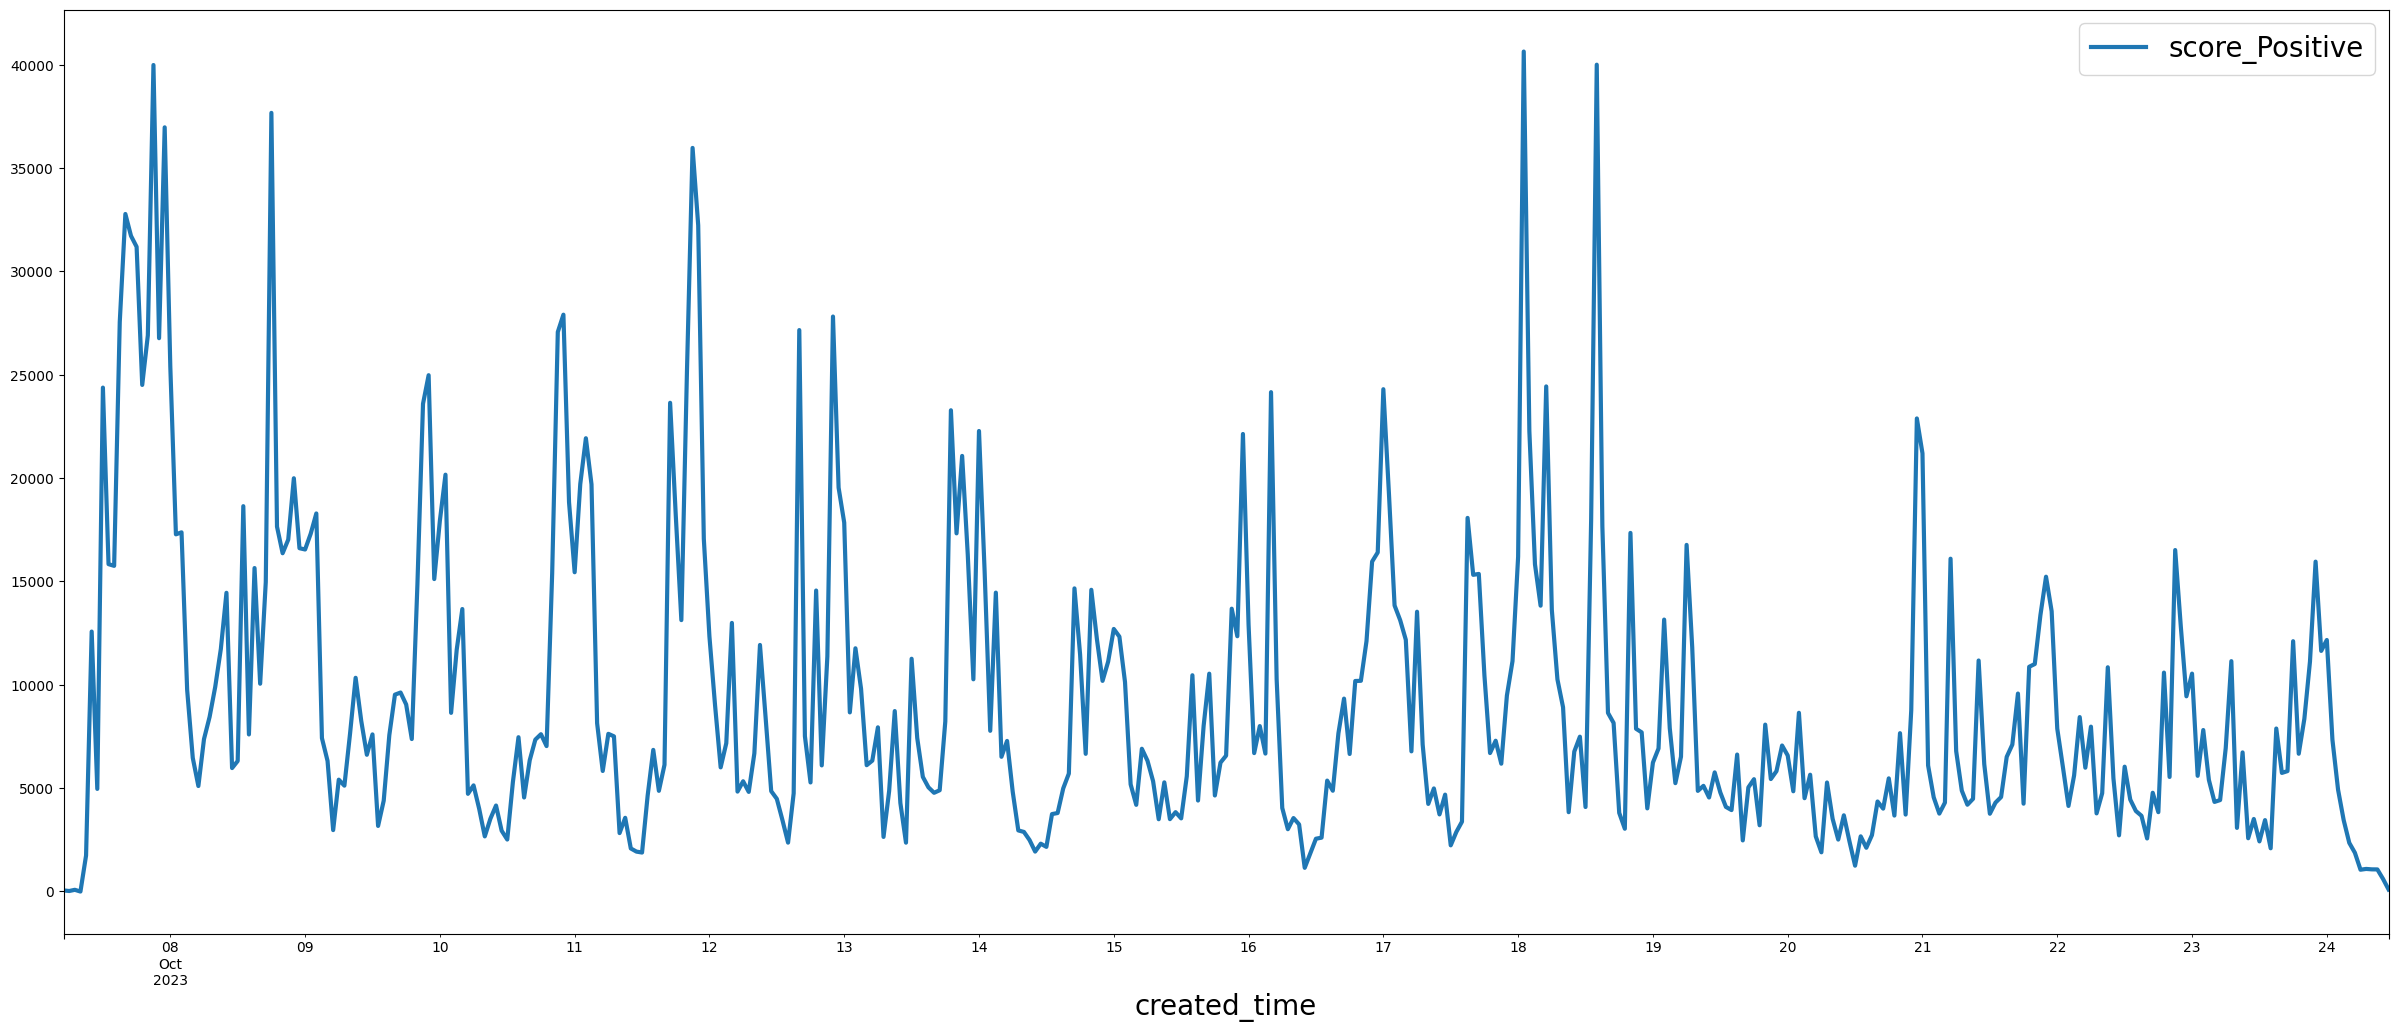

In [4]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [5]:
#для предсказания, поделим наш дадасет на выборки
train_df = data[:-24]
test_df = data[-24:]
train_df.shape, test_df.shape

((391, 1), (24, 1))

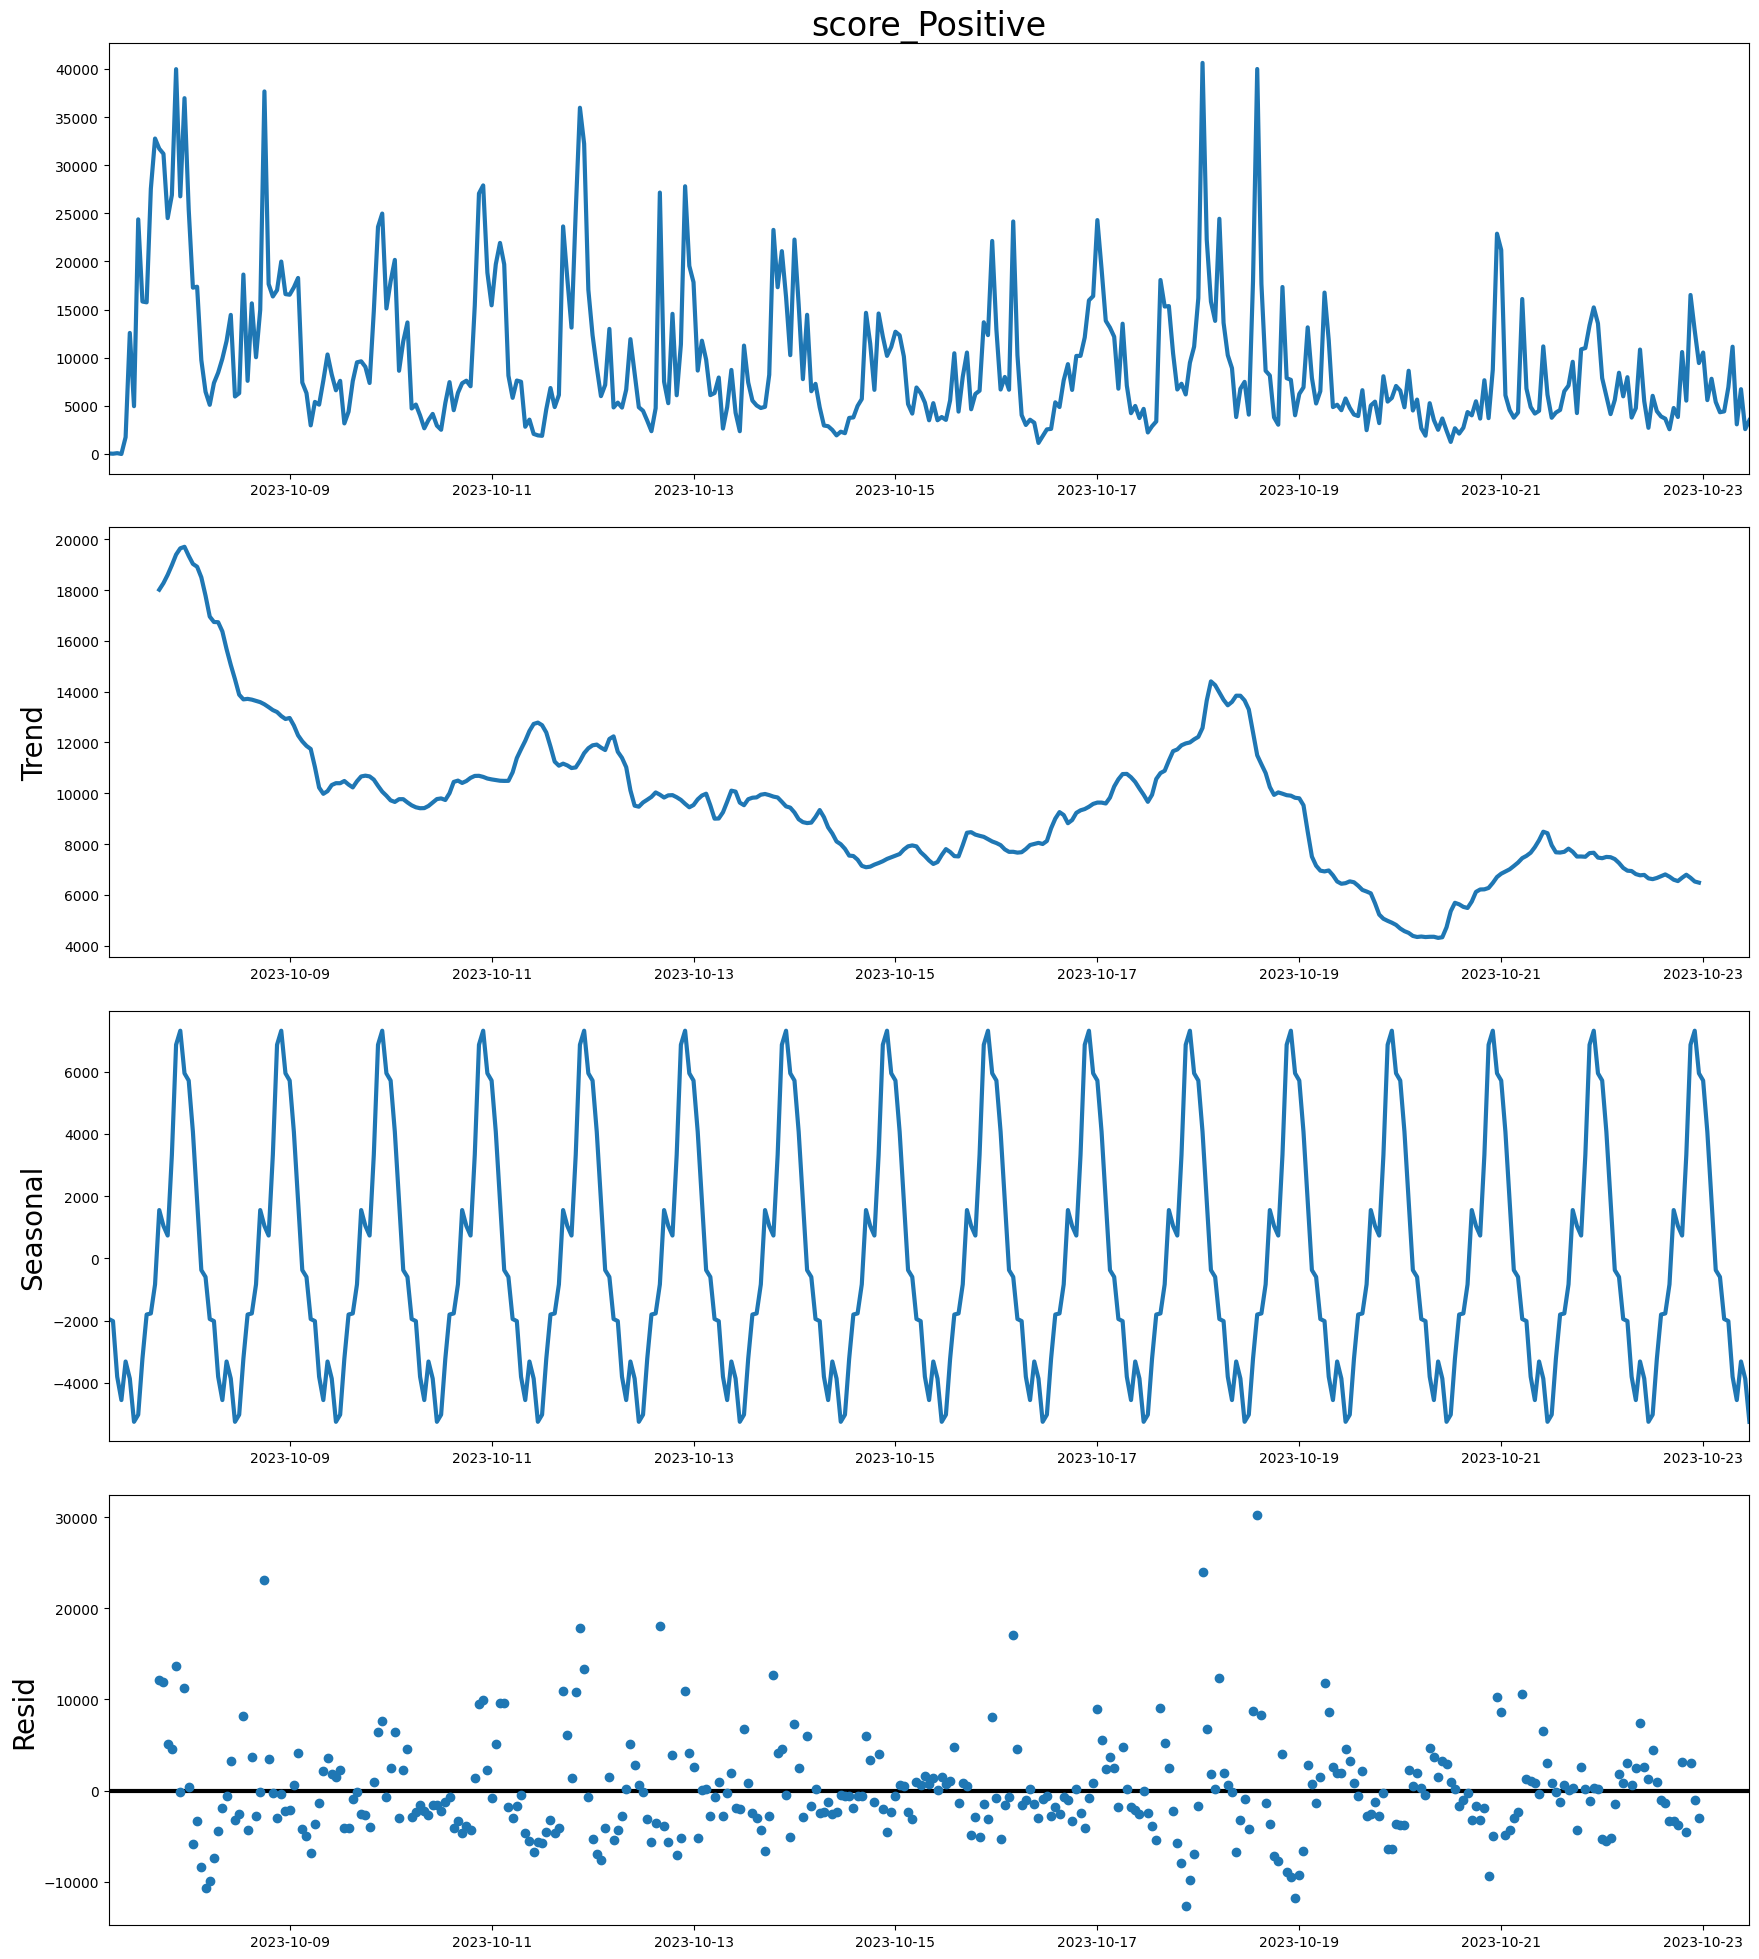

In [6]:
#
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.score_Positive)
result.plot()
plt.show()

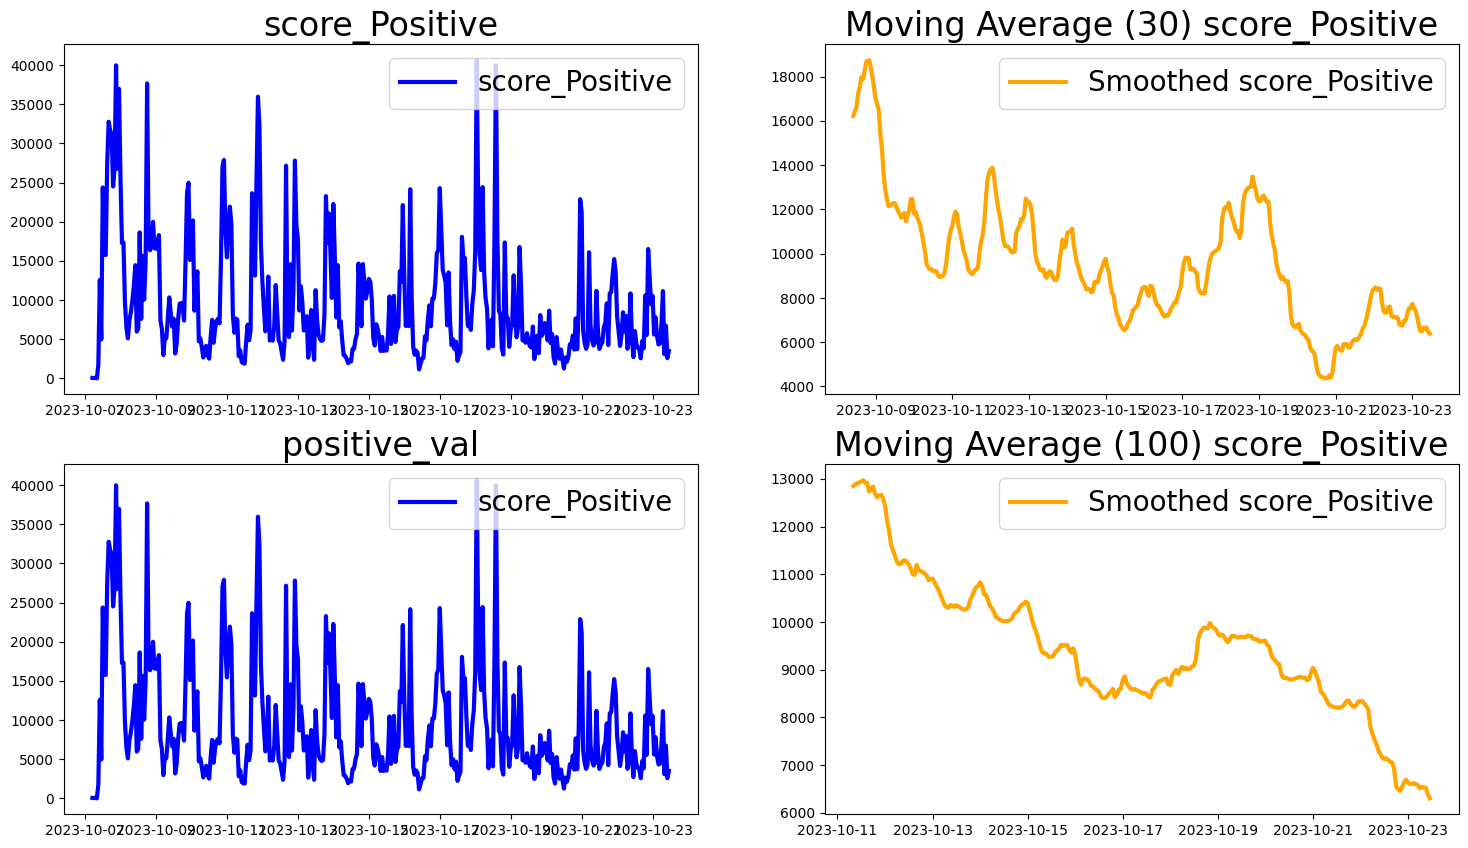

In [7]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df.score_Positive, color="blue", label="score_Positive")
ax[0, 0].set_title("score_Positive", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.score_Positive.rolling(window=30).mean(),
    color="orange",
    label="Smoothed score_Positive",
)

ax[0, 1].set_title("Moving Average (30) score_Positive", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.score_Positive, color="blue", label="score_Positive")
ax[1, 0].set_title("positive_val", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.score_Positive.rolling(window=100).mean(),
    color="orange",
    label="Smoothed score_Positive",
)

ax[1, 1].set_title("Moving Average (100) score_Positive", size=24)
ax[1, 1].legend()

plt.show()

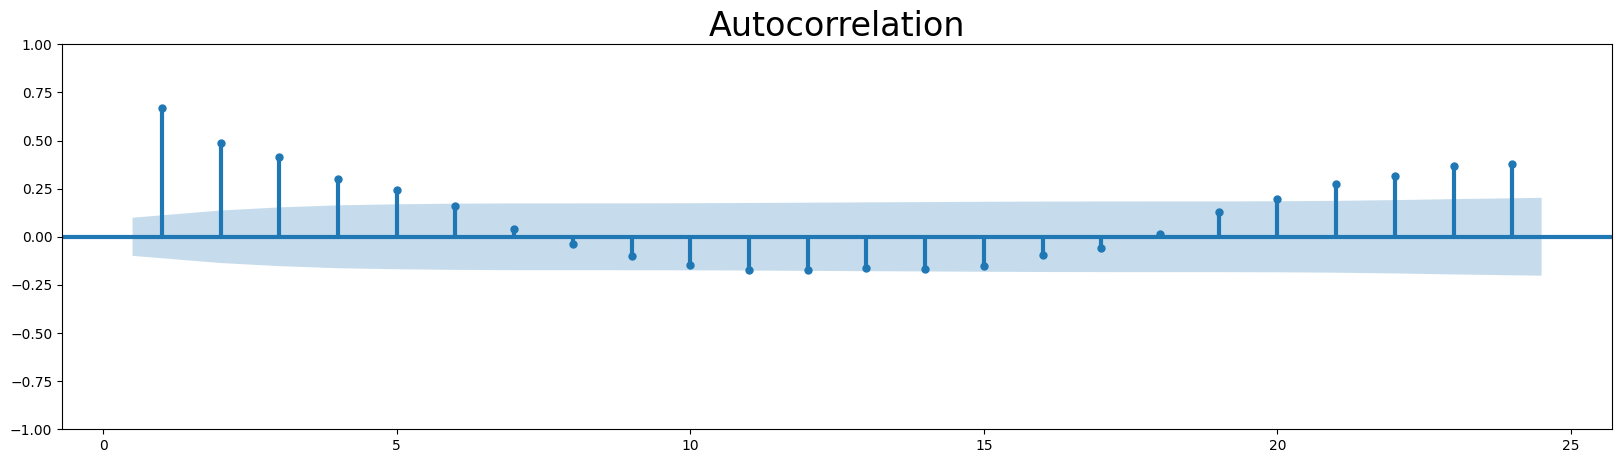

In [8]:

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.score_Positive, lags=24, zero=False)
plt.show()

присутствует дневная сезонность кратная 24 часам

In [9]:
result = adfuller(train_df["score_Positive"])

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: -6.1904656804194556
p-value: 6.140621537543522e-08
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [10]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=40)
    sgt.plot_pacf(series, ax=axes[1], lags=40, method="ywm")
    plt.show()

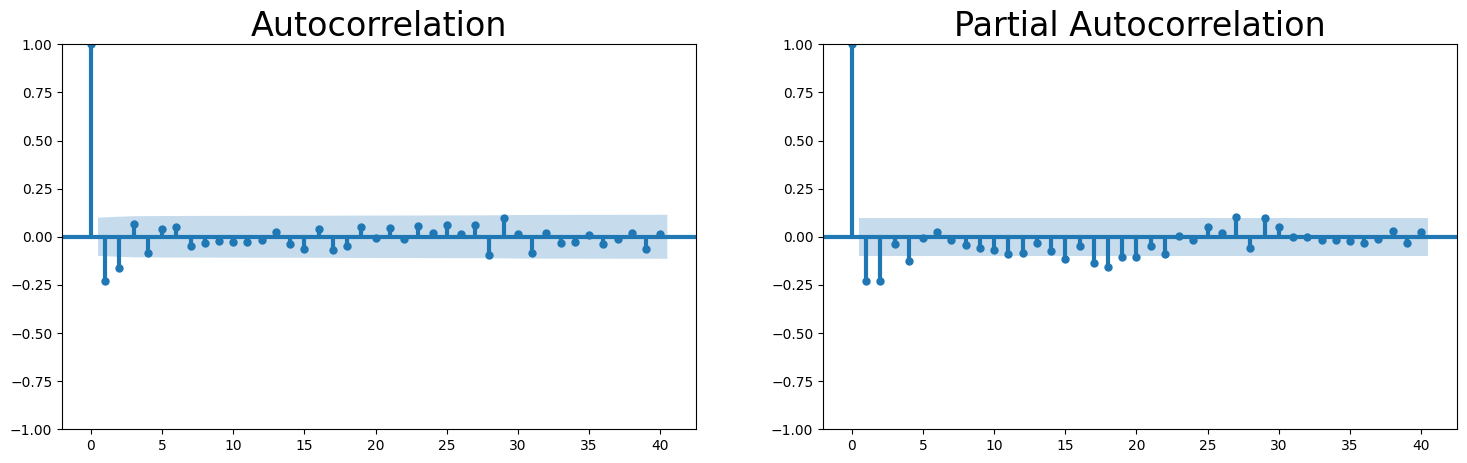

(-10.20273876781389,
 5.9117576646031344e-18,
 17,
 372,
 {'1%': -3.4480516066132636,
  '5%': -2.869340997473759,
  '10%': -2.5709257824604},
 7451.14674911701)

In [11]:
plot_acf_pacf(train_df["score_Positive"].diff().dropna())
adfuller(train_df["score_Positive"].diff().dropna())

In [12]:


arima_model = ARIMA(train_df["score_Positive"].dropna(), order=(2, 1, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\Psa1kl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\Psa1kl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\Psa1kl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         score_Positive   No. Observations:                  391
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3910.977
Date:                Mon, 30 Oct 2023   AIC                           7833.954
Time:                        11:12:12   BIC                           7857.751
Sample:                    10-07-2023   HQIC                          7843.387
                         - 10-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2075      0.288      0.721      0.471      -0.356       0.771
ar.L2          0.4529      0.187      2.422      0.015       0.086       0.819
ma.L1         -0.5758      0.288     -1.998      0.046      -1.141      -0.011
ma.L2         -0.6214      0.264     -2.354      0.019      -1.139      -0.104
ma.L3          0.2080      0.074      2.819      0.005       0.063       0.353
sigma2      3.127e+07    7.5e-10   4.17e+16      0.000    3.13e+07    3.13e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               481.61
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             1.67
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.07e+32. Standard errors may be unstable.
"""

In [13]:


model = SARIMAX(train_df["score_Positive"].dropna(), order=(1, 1, 2))
model_fit = model.fit()
model_fit.summary()

c:\Users\Psa1kl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\Psa1kl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         score_Positive   No. Observations:                  391
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -3924.862
Date:                Mon, 30 Oct 2023   AIC                           7857.725
Time:                        11:12:12   BIC                           7873.589
Sample:                    10-07-2023   HQIC                          7864.013
                         - 10-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3909      0.185     -2.114      0.034      -0.753      -0.029
ma.L1          0.0911      0.181      0.503      0.615      -0.264       0.446
ma.L2         -0.3130      0.062     -5.081      0.000      -0.434      -0.192
sigma2      3.154e+07   3.01e-09   1.05e+16      0.000    3.15e+07    3.15e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               306.72
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.26
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.26e+32. Standard errors may be unstable.
"""

In [14]:
seas_model = SARIMAX(
    train_df["score_Positive"].dropna(), order=(1, 1, 2), seasonal_order=(2, 1, 2, 24)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

c:\Users\Psa1kl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\Psa1kl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     score_Positive   No. Observations:                  391
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 24)   Log Likelihood               -3699.729
Date:                            Mon, 30 Oct 2023   AIC                           7415.458
Time:                                    11:12:19   BIC                           7446.679
Sample:                                10-07-2023   HQIC                          7427.864
                                     - 10-23-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1703      0.294      0.579      0.563      -0.407       0.747
ma.L1         -0.6396      0.296     -2.161      0.031      -1.220      -0.059
ma.L2         -0.2009      0.216     -0.928      0.353      -0.625       0.223
ar.S.L24      -0.2884      1.395     -0.207      0.836      -3.022       2.446
ar.S.L48      -0.0767      0.123     -0.624      0.532      -0.318       0.164
ma.S.L24      -0.5069      1.401     -0.362      0.717      -3.253       2.239
ma.S.L48      -0.1992      1.152     -0.173      0.863      -2.456       2.058
sigma2      5.211e+07   1.29e-07   4.03e+14      0.000    5.21e+07    5.21e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               318.93
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.16
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+31. Standard errors may be unstable.
"""

In [16]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["score_Positive"] = data["score_Positive"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower score_Positive"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper score_Positive"]

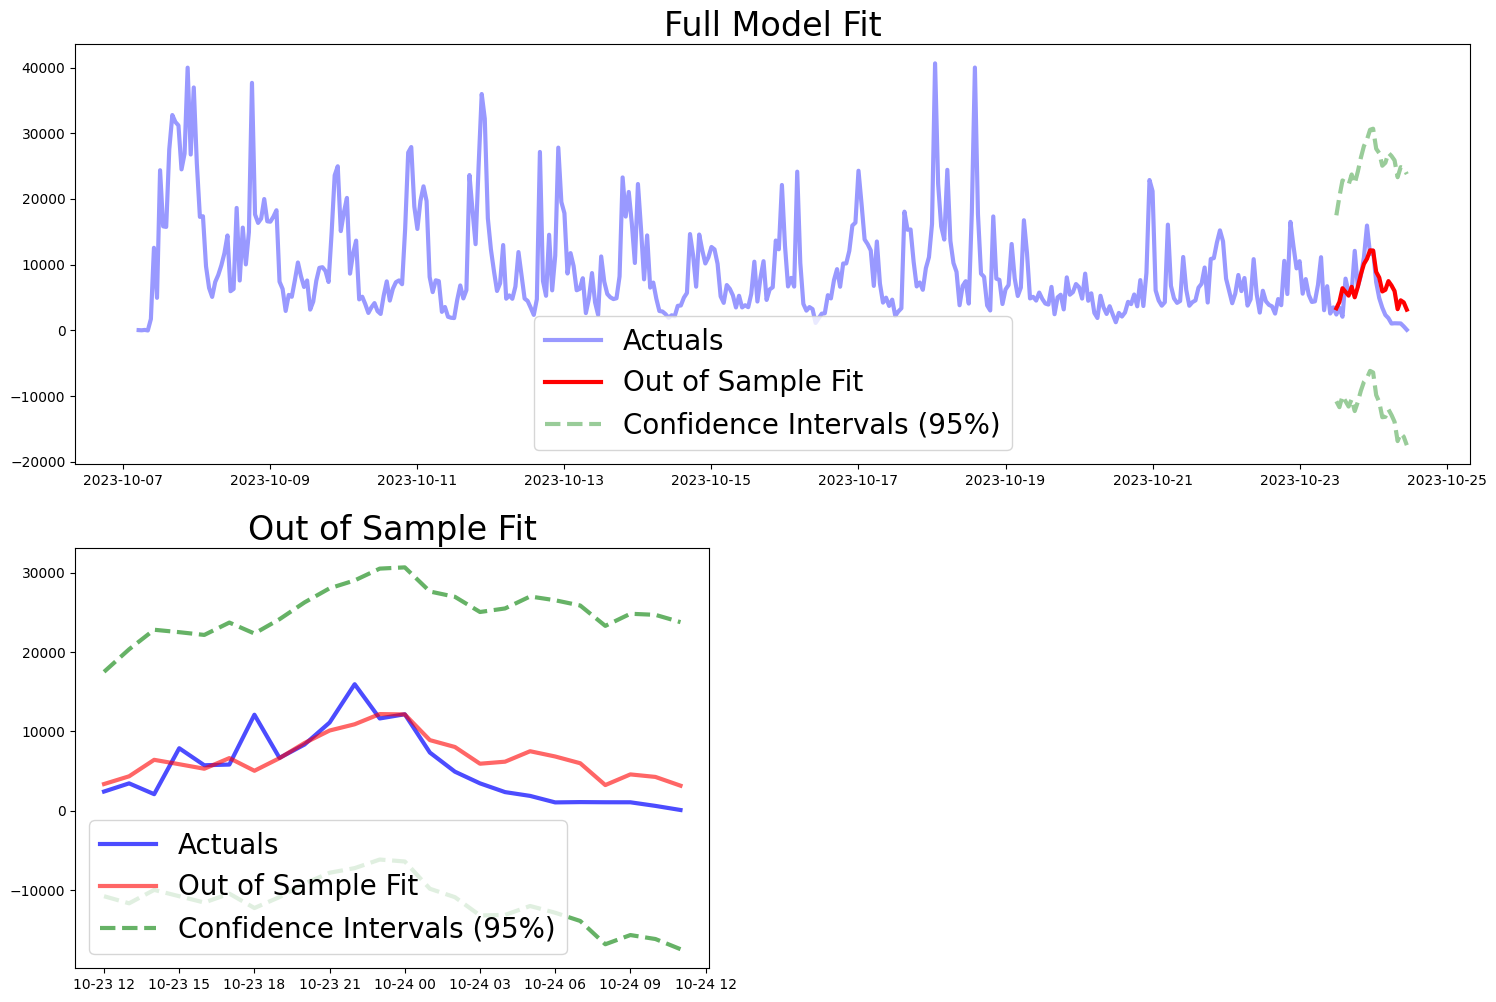

In [17]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["score_Positive"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["score_Positive"], color="blue", label="Actuals", alpha=0.7
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [18]:


smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=8049.704, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=7953.879, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=8032.577, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=7927.573, Time=0.07 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=7923.587, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=7958.596, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=7919.964, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=7946.276, Time=0.05 sec
 ARIMA(0,1,1)(2,1,1)[5]             : AIC=7856.267, Time=0.14 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  391
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 5)   Log Likelihood               -3908.458
Date:                             Mon, 30 Oct 2023   AIC                           7830.917
Time:                                     11:12:48   BIC                           7858.589
Sample:                                 10-07-2023   HQIC                          7841.892
                                      - 10-23-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2458      0.573      0.429      0.668      -0.877       1.369
ar.L2          0.4417      0.390      1.131      0.258      -0.324       1.207
ma.L1         -0.6086      0.573     -1.062      0.288      -1.732       0.515
ma.L2         -0.5888      0.544     -1.082      0.279      -1.656       0.478
ma.L3          0.2094      0.139      1.510      0.131      -0.062       0.481
ma.S.L5       -0.9408      0.048    -19.596      0.000      -1.035      -0.847
sigma2      6.089e+07   1.88e-09   3.24e+16      0.000    6.09e+07    6.09e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               313.81
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.41e+33. Standard errors may be unstable.
"""

# Вывод по модели: 

- Модель по прогнозированию тренда, улавливает все параметры, так же качественно делает предсказание, что видно на графике.
- Тренд у нас на явное понижение, чем это обусловленно? Ифнормация в современном мире очень быстро замещается новой. Скорее всего если будут какие-то изменения в повестке конфликта, тренд изменится.
* Так же:
- Видно, что в предсказании мы не учли разброс — прогноз хочется «вытянуть» вниз, таким образом увеличивая дисперсию. Такая проблема часто возникает в волатильных временных рядах.
- Попробуем применить GARCH модель.

# GARCH model

In [19]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data['score_Positive'].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, 'score_Positive'] = train_df['score_Positive'].dropna()

In [28]:
from arch import arch_model

model = arch_model(garch_df['score_Positive'].dropna(), p=2, q=2)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)


Iteration:      5,   Func. Count:     37,   Neg. LLF: 3995.6243134769225
Iteration:     10,   Func. Count:     72,   Neg. LLF: 3995.5699865250012
Iteration:     15,   Func. Count:    107,   Neg. LLF: 3979.0271390051003
Iteration:     20,   Func. Count:    142,   Neg. LLF: 3977.148646818646
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3976.8579287475945
            Iterations: 20
            Function evaluations: 146
            Gradient evaluations: 20


c:\Users\Psa1kl\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.538e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [29]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         score_Positive   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3976.86
Distribution:                  Normal   AIC:                           7965.72
Method:            Maximum Likelihood   BIC:                           7989.53
                                        No. Observations:                  391
Date:                Mon, Oct 30 2023   Df Residuals:                      390
Time:                        11:39:15   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu          7428.7260    507.813     14.629  1.839e-48 [6.433e+03,8.424e+03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.7688e+07  1.134e+07      2.441  1.466e-02 [5.453e+06,4.992e+07]
alpha[1]       0.6545      0.227      2.878  3.998e-03     [  0.209,  1.100]
alpha[2]   4.0269e-11      0.432  9.317e-11      1.000     [ -0.847,  0.847]
beta[1]    5.9766e-11      0.445  1.343e-10      1.000     [ -0.872,  0.872]
beta[2]    1.7128e-11      0.157  1.089e-10      1.000     [ -0.308,  0.308]
============================================================================

Covariance estimator: robust
"""

In [30]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

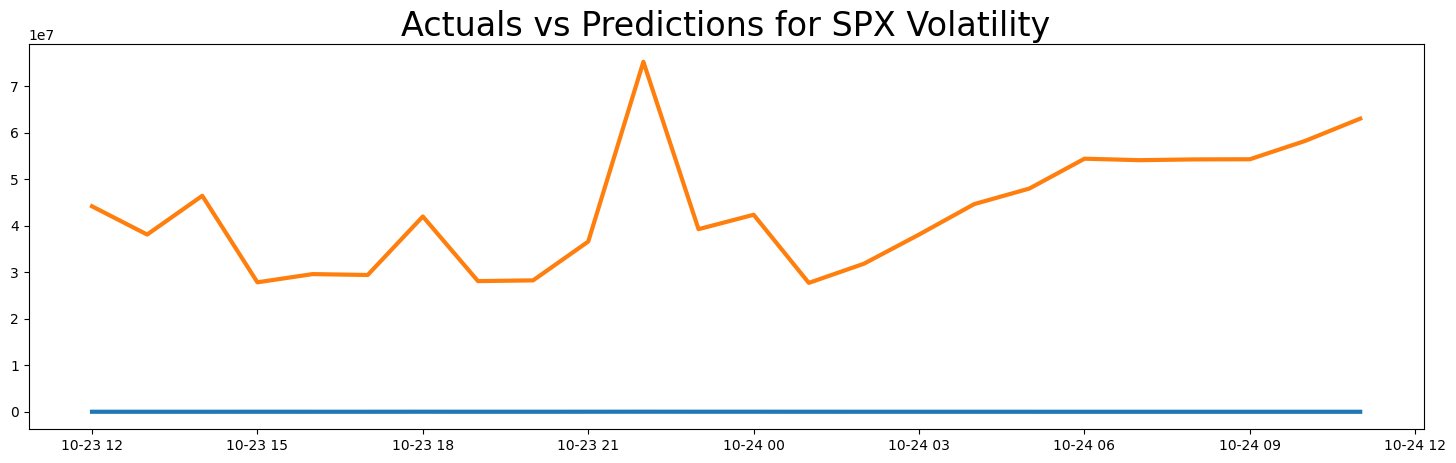

In [31]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df['score_Positive'].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()


# Вывод:

Так как много выбросов(комментариев с большим колличеством лайков), это модель не сравляется. Оставим SARIMA.

In [34]:
# Сериализуем pipeline и записываем результат в файл
with open('my_pipeline.pkl', 'wb') as output:
    pickle.dump(model_results, output)